# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Sat Jan 20 01:16:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.7 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3
!pip install codecarbon

  Preparing metadata (setup.py) ... - \ done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=272003bc7fa70c9894046e119349a1db64db151e707697a7b9208a321daef5a6
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 4.7 MB/s eta 0:00:00


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [5]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon INFO @ 01:18:30] [setup] RAM Tracking...
[codecarbon INFO @ 01:18:30] [setup] GPU Tracking...
[codecarbon INFO @ 01:18:30] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:18:30] [setup] CPU Tracking...
[codecarbon WARNING @ 01:18:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:18:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:18:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:18:31] >>> Tracker's metadata:
[codecarbon INFO @ 01:18:31]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:18:31]   Python version: 3.10.10
[codecarbon INFO @ 01:18:31]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 01:18:31]   Available RAM : 31.358 GB
[codecarbon INFO @ 01:18:31]   CPU count: 4
[codecarbon INFO @ 01:18:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:18:31]   GPU

In [6]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [7]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [8]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 01:18:50] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:18:50] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 19.73900745992667 W
[codecarbon INFO @ 01:18:50] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:18:50] 0.000309 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:19:05] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:19:05] Energy consumed for all GPUs : 0.000165 kWh. Total GPU Power : 19.805992019180568 W
[codecarbon INFO @ 01:19:05] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:19:05] 0.000617 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:19:20] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:19:20] Energy consumed for all GPUs : 0.000247 kWh. Total GPU Power : 19.7712392806

'/kaggle/working/dataset'

In [9]:
data_dir  = '/kaggle/working/dataset'

In [10]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [11]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/plastic/plastic_2672.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2672.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1903.jpg is not an image
/kaggle/working/dataset/plastic/plastic_1903.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2377.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2377.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_929.jpg is not an image
/kaggle/working/dataset/plastic/plastic_929.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1932.jpg is not an image
/kaggle/working/dataset/plastic/plastic_1932.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_3.jpg is not an image
/kaggle/working/dataset/plastic/plastic_3.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1486.jpg is not an image
/kaggle/working/dataset/plastic

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [12]:
os.mkdir('data')

In [13]:
os.chdir('data')

In [14]:
os.getcwd()

'/kaggle/working/data'

In [15]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [16]:
os.chdir('/kaggle/working/')

In [17]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [18]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [19]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23584 files [00:03, 6401.10 files/s]


In [20]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [21]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [22]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

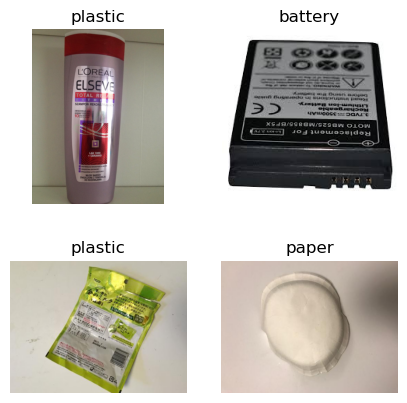

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [24]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Trash: 667
Plastic: 2013
Cardboard: 1864
Shoes: 1581
Clothes: 4260
Paper: 2169
Metal: 1494
Battery: 756
Biological: 788
Glass: 3272

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [25]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [26]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

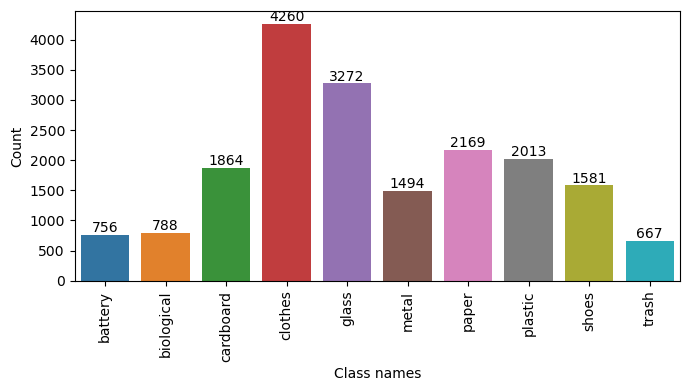

In [27]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [28]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in trash
Deleted 1013 in plastic


[codecarbon INFO @ 01:21:05] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:21:05] Energy consumed for all GPUs : 0.000819 kWh. Total GPU Power : 19.529053904416465 W
[codecarbon INFO @ 01:21:05] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:21:05] 0.003080 kWh of electricity used since the beginning.


Deleted 864 in cardboard
Deleted 581 in shoes
Deleted 3260 in clothes
Deleted 1169 in paper
Deleted 494 in metal
Deleted 0 in battery
Deleted 0 in biological
Deleted 2272 in glass


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [29]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

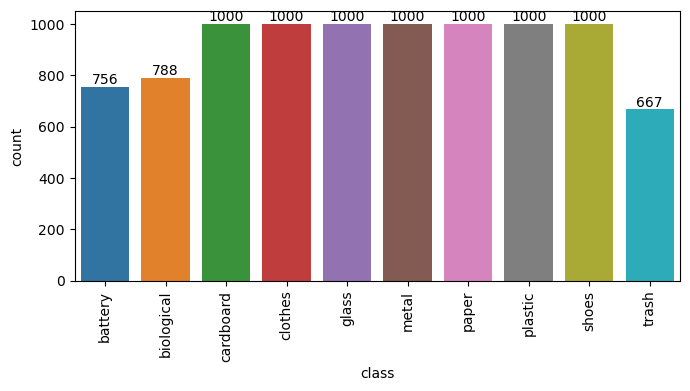

In [30]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [31]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [32]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 414.5447
Mean Height: 393.7798


Let's set the size of the input data (image size) taking into account the found average values

In [33]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [34]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [35]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [36]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [37]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


[codecarbon INFO @ 01:21:20] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:21:20] Energy consumed for all GPUs : 0.000908 kWh. Total GPU Power : 21.376023801521132 W
[codecarbon INFO @ 01:21:20] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:21:20] 0.003395 kWh of electricity used since the beginning.


In [38]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


Create directories for train and test logs and write logs to it 

In [39]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [40]:
prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")


[codecarbon INFO @ 01:21:20] Energy consumed for RAM : 0.000540 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:21:20] Energy consumed for all GPUs : 0.000917 kWh. Total GPU Power : 58.52432283703557 W
[codecarbon INFO @ 01:21:20] Energy consumed for all CPUs : 0.001955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:21:20] 0.003413 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.0009742934104911306 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the MobileNet model was selected.


In [41]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon INFO @ 01:21:21] [setup] RAM Tracking...
[codecarbon INFO @ 01:21:21] [setup] GPU Tracking...
[codecarbon INFO @ 01:21:21] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:21:21] [setup] CPU Tracking...
[codecarbon WARNING @ 01:21:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:21:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:21:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:21:22] >>> Tracker's metadata:
[codecarbon INFO @ 01:21:22]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:21:22]   Python version: 3.10.10
[codecarbon INFO @ 01:21:22]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 01:21:22]   Available RAM : 31.358 GB
[codecarbon INFO @ 01:21:22]   CPU count: 4
[codecarbon INFO @ 01:21:22]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:21:22]   GPU

Loading the model

In [42]:
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

17225924/17225924 [==============================] - 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [43]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 200, 200, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 200, 200, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 200, 200, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 200, 200, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 200, 200, 32)     128       
 ation)                                         

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [44]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [45]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

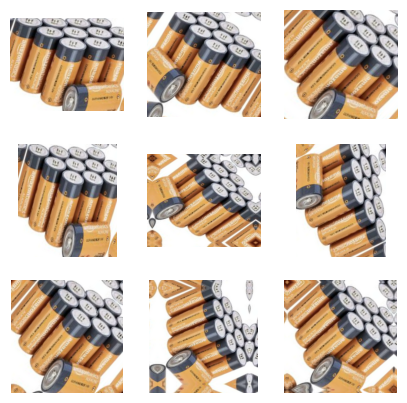

In [46]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [47]:
name="MobileNet"

MobileNet_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [48]:
MobileNet_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [49]:
MobileNet_model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 mobilenet_1.00_224 (Functio  (None, 12, 12, 1024)     3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                         

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [50]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [51]:
MobileNet_callback = create_callback(name)

Let's set the number of training epochs

In [52]:
EPOCH=20

Let's train the model

In [53]:
import time
start_time = time.time()
MobileNet_history = MobileNet_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=MobileNet_callback)

Epoch 1/20
  2/288 [..............................] - ETA: 4:43 - loss: 2.7224 - accuracy: 0.1719 

[codecarbon INFO @ 01:21:40] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:21:40] Energy consumed for all GPUs : 0.000258 kWh. Total GPU Power : 62.00856338105433 W
[codecarbon INFO @ 01:21:40] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:21:40] 0.000485 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 4:55 - loss: 2.2865 - accuracy: 0.2031

[codecarbon INFO @ 01:21:55] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:21:55] Energy consumed for all GPUs : 0.000661 kWh. Total GPU Power : 96.60294082610248 W
[codecarbon INFO @ 01:21:55] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:21:55] 0.001113 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 4:37 - loss: 2.1722 - accuracy: 0.2323

[codecarbon INFO @ 01:22:10] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:22:10] Energy consumed for all GPUs : 0.001065 kWh. Total GPU Power : 97.07081220212109 W
[codecarbon INFO @ 01:22:10] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:22:10] 0.001743 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 4:09 - loss: 2.0871 - accuracy: 0.2636

[codecarbon INFO @ 01:22:25] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:22:25] Energy consumed for all GPUs : 0.001470 kWh. Total GPU Power : 97.17242654183704 W
[codecarbon INFO @ 01:22:25] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:22:25] 0.002374 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 3:41 - loss: 2.0430 - accuracy: 0.2842

[codecarbon INFO @ 01:22:40] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:22:40] Energy consumed for all GPUs : 0.001877 kWh. Total GPU Power : 97.70653027556921 W
[codecarbon INFO @ 01:22:40] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:22:40] 0.003007 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 3:23 - loss: 1.9932 - accuracy: 0.3018

[codecarbon INFO @ 01:22:55] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:22:55] Energy consumed for all GPUs : 0.002284 kWh. Total GPU Power : 97.77741361553072 W
[codecarbon INFO @ 01:22:55] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:22:55] 0.003640 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 2:58 - loss: 1.9501 - accuracy: 0.3173

[codecarbon INFO @ 01:23:10] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:10] Energy consumed for all GPUs : 0.002694 kWh. Total GPU Power : 98.568772817487 W
[codecarbon INFO @ 01:23:10] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:10] 0.004277 kWh of electricity used since the beginning.


114/288 [==========>...................] - ETA: 2:43 - loss: 1.9208 - accuracy: 0.3309

[codecarbon INFO @ 01:23:25] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:25] Energy consumed for all GPUs : 0.003105 kWh. Total GPU Power : 98.4911938145402 W
[codecarbon INFO @ 01:23:25] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:25] 0.004913 kWh of electricity used since the beginning.


131/288 [============>.................] - ETA: 2:26 - loss: 1.8947 - accuracy: 0.3392

[codecarbon INFO @ 01:23:40] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:40] Energy consumed for all GPUs : 0.003513 kWh. Total GPU Power : 98.13385143779507 W
[codecarbon INFO @ 01:23:40] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:40] 0.005548 kWh of electricity used since the beginning.


150/288 [==============>...............] - ETA: 2:06 - loss: 1.8667 - accuracy: 0.3490

[codecarbon INFO @ 01:23:55] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:55] Energy consumed for all GPUs : 0.003923 kWh. Total GPU Power : 98.26637703980744 W
[codecarbon INFO @ 01:23:55] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:55] 0.006183 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 1:50 - loss: 1.8440 - accuracy: 0.3559

[codecarbon INFO @ 01:24:10] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:10] Energy consumed for all GPUs : 0.004330 kWh. Total GPU Power : 97.81865158872962 W
[codecarbon INFO @ 01:24:10] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:10] 0.006816 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:32 - loss: 1.8234 - accuracy: 0.3660

[codecarbon INFO @ 01:24:25] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:25] Energy consumed for all GPUs : 0.004739 kWh. Total GPU Power : 98.25080812434936 W
[codecarbon INFO @ 01:24:25] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:25] 0.007452 kWh of electricity used since the beginning.


202/288 [====================>.........] - ETA: 1:17 - loss: 1.8020 - accuracy: 0.3753

[codecarbon INFO @ 01:24:40] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:40] Energy consumed for all GPUs : 0.005146 kWh. Total GPU Power : 97.72760126234658 W
[codecarbon INFO @ 01:24:40] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:40] 0.008085 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 57s - loss: 1.7778 - accuracy: 0.3840

[codecarbon INFO @ 01:24:55] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:55] Energy consumed for all GPUs : 0.005551 kWh. Total GPU Power : 97.18962750251424 W
[codecarbon INFO @ 01:24:55] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:55] 0.008715 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 40s - loss: 1.7617 - accuracy: 0.3915

[codecarbon INFO @ 01:25:10] Energy consumed for RAM : 0.000735 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:10] Energy consumed for all GPUs : 0.005960 kWh. Total GPU Power : 98.2772689906268 W
[codecarbon INFO @ 01:25:10] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:10] 0.009351 kWh of electricity used since the beginning.


263/288 [==========================>...] - ETA: 21s - loss: 1.7370 - accuracy: 0.4014

[codecarbon INFO @ 01:25:25] Energy consumed for RAM : 0.000783 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:25] Energy consumed for all GPUs : 0.006368 kWh. Total GPU Power : 97.85736250732471 W
[codecarbon INFO @ 01:25:25] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:25] 0.009984 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 4s - loss: 1.7232 - accuracy: 0.4058

[codecarbon INFO @ 01:25:40] Energy consumed for RAM : 0.000832 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:40] Energy consumed for all GPUs : 0.006774 kWh. Total GPU Power : 97.69316100572378 W
[codecarbon INFO @ 01:25:40] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:40] 0.010617 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 1.7202 - accuracy: 0.4057

[codecarbon INFO @ 01:25:55] Energy consumed for RAM : 0.000881 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:55] Energy consumed for all GPUs : 0.007166 kWh. Total GPU Power : 94.11928665305133 W
[codecarbon INFO @ 01:25:55] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:55] 0.011235 kWh of electricity used since the beginning.


288/288 [==============================] - 263s 894ms/step - loss: 1.7202 - accuracy: 0.4057 - val_loss: 1.2957 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 2/20
 20/288 [=>............................] - ETA: 3:10 - loss: 1.4696 - accuracy: 0.5063

[codecarbon INFO @ 01:26:10] Energy consumed for RAM : 0.000930 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:10] Energy consumed for all GPUs : 0.007567 kWh. Total GPU Power : 96.30233245237802 W
[codecarbon INFO @ 01:26:10] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:10] 0.011862 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 2:47 - loss: 1.4696 - accuracy: 0.4956

[codecarbon INFO @ 01:26:25] Energy consumed for RAM : 0.000979 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:25] Energy consumed for all GPUs : 0.007972 kWh. Total GPU Power : 97.27746613325372 W
[codecarbon INFO @ 01:26:25] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:25] 0.012493 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 2:27 - loss: 1.4763 - accuracy: 0.4901

[codecarbon INFO @ 01:26:40] Energy consumed for RAM : 0.001028 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:40] Energy consumed for all GPUs : 0.008378 kWh. Total GPU Power : 97.4680402215056 W
[codecarbon INFO @ 01:26:40] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:40] 0.013125 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 2:19 - loss: 1.4583 - accuracy: 0.4985

[codecarbon INFO @ 01:26:55] Energy consumed for RAM : 0.001077 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:55] Energy consumed for all GPUs : 0.008784 kWh. Total GPU Power : 97.38155574176776 W
[codecarbon INFO @ 01:26:55] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:55] 0.013757 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 2:03 - loss: 1.4596 - accuracy: 0.4954

[codecarbon INFO @ 01:27:10] Energy consumed for RAM : 0.001126 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:10] Energy consumed for all GPUs : 0.009190 kWh. Total GPU Power : 97.51145177604 W
[codecarbon INFO @ 01:27:10] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:10] 0.014389 kWh of electricity used since the beginning.


130/288 [============>.................] - ETA: 1:48 - loss: 1.4484 - accuracy: 0.5000

[codecarbon INFO @ 01:27:25] Energy consumed for RAM : 0.001175 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:25] Energy consumed for all GPUs : 0.009595 kWh. Total GPU Power : 97.20377763792669 W
[codecarbon INFO @ 01:27:25] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:25] 0.015020 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 1:32 - loss: 1.4369 - accuracy: 0.5053

[codecarbon INFO @ 01:27:40] Energy consumed for RAM : 0.001224 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:40] Energy consumed for all GPUs : 0.010000 kWh. Total GPU Power : 97.3436978711223 W
[codecarbon INFO @ 01:27:40] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:40] 0.015651 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 1:16 - loss: 1.4318 - accuracy: 0.5082

[codecarbon INFO @ 01:27:55] Energy consumed for RAM : 0.001273 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:55] Energy consumed for all GPUs : 0.010405 kWh. Total GPU Power : 97.14359299389876 W
[codecarbon INFO @ 01:27:55] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:55] 0.016282 kWh of electricity used since the beginning.


198/288 [===================>..........] - ETA: 1:01 - loss: 1.4242 - accuracy: 0.5125

[codecarbon INFO @ 01:28:10] Energy consumed for RAM : 0.001322 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:10] Energy consumed for all GPUs : 0.010811 kWh. Total GPU Power : 97.3790994635994 W
[codecarbon INFO @ 01:28:10] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:10] 0.016914 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 46s - loss: 1.4265 - accuracy: 0.5116

[codecarbon INFO @ 01:28:25] Energy consumed for RAM : 0.001371 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:25] Energy consumed for all GPUs : 0.011215 kWh. Total GPU Power : 97.19489562481297 W
[codecarbon INFO @ 01:28:25] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:25] 0.017544 kWh of electricity used since the beginning.


244/288 [========================>.....] - ETA: 29s - loss: 1.4228 - accuracy: 0.5131

[codecarbon INFO @ 01:28:40] Energy consumed for RAM : 0.001420 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:40] Energy consumed for all GPUs : 0.011621 kWh. Total GPU Power : 97.35961990398052 W
[codecarbon INFO @ 01:28:40] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:40] 0.018176 kWh of electricity used since the beginning.


268/288 [==========================>...] - ETA: 13s - loss: 1.4162 - accuracy: 0.5141

[codecarbon INFO @ 01:28:55] Energy consumed for RAM : 0.001469 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:55] Energy consumed for all GPUs : 0.012025 kWh. Total GPU Power : 97.20280838090432 W
[codecarbon INFO @ 01:28:55] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:55] 0.018807 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 1.4139 - accuracy: 0.5157

[codecarbon INFO @ 01:29:10] Energy consumed for RAM : 0.001518 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:10] Energy consumed for all GPUs : 0.012426 kWh. Total GPU Power : 96.27023970358479 W
[codecarbon INFO @ 01:29:10] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:10] 0.019434 kWh of electricity used since the beginning.


288/288 [==============================] - 200s 695ms/step - loss: 1.4139 - accuracy: 0.5157 - val_loss: 1.3370 - val_accuracy: 0.5178 - lr: 0.0010
Epoch 3/20
 13/288 [>.............................] - ETA: 3:06 - loss: 1.3663 - accuracy: 0.5216

[codecarbon INFO @ 01:29:25] Energy consumed for RAM : 0.001567 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:25] Energy consumed for all GPUs : 0.012825 kWh. Total GPU Power : 95.63695448083794 W
[codecarbon INFO @ 01:29:25] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:25] 0.020058 kWh of electricity used since the beginning.


 35/288 [==>...........................] - ETA: 2:50 - loss: 1.3347 - accuracy: 0.5509

[codecarbon INFO @ 01:29:40] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:40] Energy consumed for all GPUs : 0.013230 kWh. Total GPU Power : 97.3230218889294 W
[codecarbon INFO @ 01:29:40] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:40] 0.020689 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 2:34 - loss: 1.3532 - accuracy: 0.5422

[codecarbon INFO @ 01:29:55] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:55] Energy consumed for all GPUs : 0.013634 kWh. Total GPU Power : 97.16998546829915 W
[codecarbon INFO @ 01:29:55] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:55] 0.021320 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 2:12 - loss: 1.3602 - accuracy: 0.5407

[codecarbon INFO @ 01:30:10] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:10] Energy consumed for all GPUs : 0.014040 kWh. Total GPU Power : 97.32151043163628 W
[codecarbon INFO @ 01:30:10] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:10] 0.021951 kWh of electricity used since the beginning.


105/288 [=========>....................] - ETA: 1:59 - loss: 1.3554 - accuracy: 0.5411

[codecarbon INFO @ 01:30:25] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:25] Energy consumed for all GPUs : 0.014445 kWh. Total GPU Power : 97.27422690579269 W
[codecarbon INFO @ 01:30:25] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:25] 0.022582 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 1:42 - loss: 1.3596 - accuracy: 0.5407

[codecarbon INFO @ 01:30:40] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:40] Energy consumed for all GPUs : 0.014850 kWh. Total GPU Power : 97.38146549518548 W
[codecarbon INFO @ 01:30:40] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:40] 0.023214 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 1:24 - loss: 1.3494 - accuracy: 0.5423

[codecarbon INFO @ 01:30:55] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:55] Energy consumed for all GPUs : 0.015255 kWh. Total GPU Power : 97.13784682525487 W
[codecarbon INFO @ 01:30:55] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:55] 0.023844 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 1:07 - loss: 1.3454 - accuracy: 0.5440

[codecarbon INFO @ 01:31:10] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:10] Energy consumed for all GPUs : 0.015662 kWh. Total GPU Power : 97.73742068759209 W
[codecarbon INFO @ 01:31:10] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:10] 0.024477 kWh of electricity used since the beginning.


207/288 [====================>.........] - ETA: 50s - loss: 1.3414 - accuracy: 0.5451

[codecarbon INFO @ 01:31:25] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:25] Energy consumed for all GPUs : 0.016064 kWh. Total GPU Power : 96.66598151543256 W
[codecarbon INFO @ 01:31:25] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:25] 0.025106 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 34s - loss: 1.3328 - accuracy: 0.5494

[codecarbon INFO @ 01:31:40] Energy consumed for RAM : 0.002007 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:40] Energy consumed for all GPUs : 0.016469 kWh. Total GPU Power : 97.1794668073546 W
[codecarbon INFO @ 01:31:40] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:40] 0.025736 kWh of electricity used since the beginning.


256/288 [=========================>....] - ETA: 19s - loss: 1.3305 - accuracy: 0.5504

[codecarbon INFO @ 01:31:55] Energy consumed for RAM : 0.002056 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:55] Energy consumed for all GPUs : 0.016875 kWh. Total GPU Power : 97.64892546090695 W
[codecarbon INFO @ 01:31:55] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:55] 0.026369 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 3s - loss: 1.3244 - accuracy: 0.5510

[codecarbon INFO @ 01:32:10] Energy consumed for RAM : 0.002105 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:10] Energy consumed for all GPUs : 0.017280 kWh. Total GPU Power : 97.06188203265401 W
[codecarbon INFO @ 01:32:10] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:10] 0.027000 kWh of electricity used since the beginning.


288/288 [==============================] - 187s 647ms/step - loss: 1.3237 - accuracy: 0.5512 - val_loss: 1.0865 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 4/20
  3/288 [..............................] - ETA: 2:14 - loss: 1.2700 - accuracy: 0.5312

[codecarbon INFO @ 01:32:25] Energy consumed for RAM : 0.002154 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:25] Energy consumed for all GPUs : 0.017673 kWh. Total GPU Power : 94.2298758505212 W
[codecarbon INFO @ 01:32:25] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:25] 0.027618 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 2:16 - loss: 1.2570 - accuracy: 0.5716

[codecarbon INFO @ 01:32:40] Energy consumed for RAM : 0.002203 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:40] Energy consumed for all GPUs : 0.018077 kWh. Total GPU Power : 97.19942109274687 W
[codecarbon INFO @ 01:32:40] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:40] 0.028249 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 1:56 - loss: 1.2689 - accuracy: 0.5656

[codecarbon INFO @ 01:32:55] Energy consumed for RAM : 0.002252 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:55] Energy consumed for all GPUs : 0.018482 kWh. Total GPU Power : 97.25815960641184 W
[codecarbon INFO @ 01:32:55] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:55] 0.028880 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 1:44 - loss: 1.2611 - accuracy: 0.5699

[codecarbon INFO @ 01:33:10] Energy consumed for RAM : 0.002301 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:10] Energy consumed for all GPUs : 0.018887 kWh. Total GPU Power : 97.07001251271805 W
[codecarbon INFO @ 01:33:10] Energy consumed for all CPUs : 0.008323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:10] 0.029510 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 1:37 - loss: 1.2672 - accuracy: 0.5681

[codecarbon INFO @ 01:33:25] Energy consumed for RAM : 0.002350 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:25] Energy consumed for all GPUs : 0.019291 kWh. Total GPU Power : 97.0946741421727 W
[codecarbon INFO @ 01:33:25] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:25] 0.030141 kWh of electricity used since the beginning.


140/288 [=============>................] - ETA: 1:21 - loss: 1.2528 - accuracy: 0.5723

[codecarbon INFO @ 01:33:40] Energy consumed for RAM : 0.002399 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:40] Energy consumed for all GPUs : 0.019696 kWh. Total GPU Power : 97.21663284438114 W
[codecarbon INFO @ 01:33:40] Energy consumed for all CPUs : 0.008677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:40] 0.030772 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 1:06 - loss: 1.2521 - accuracy: 0.5715

[codecarbon INFO @ 01:33:55] Energy consumed for RAM : 0.002448 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:55] Energy consumed for all GPUs : 0.020100 kWh. Total GPU Power : 97.10845947015096 W
[codecarbon INFO @ 01:33:55] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:55] 0.031402 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 49s - loss: 1.2558 - accuracy: 0.5707

[codecarbon INFO @ 01:34:10] Energy consumed for RAM : 0.002497 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:10] Energy consumed for all GPUs : 0.020504 kWh. Total GPU Power : 97.0806948891911 W
[codecarbon INFO @ 01:34:10] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:10] 0.032033 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 35s - loss: 1.2579 - accuracy: 0.5692

[codecarbon INFO @ 01:34:25] Energy consumed for RAM : 0.002546 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:25] Energy consumed for all GPUs : 0.020908 kWh. Total GPU Power : 97.05725856961084 W
[codecarbon INFO @ 01:34:25] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:25] 0.032662 kWh of electricity used since the beginning.


253/288 [=========================>....] - ETA: 18s - loss: 1.2504 - accuracy: 0.5726

[codecarbon INFO @ 01:34:40] Energy consumed for RAM : 0.002595 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:40] Energy consumed for all GPUs : 0.021313 kWh. Total GPU Power : 97.25651920632609 W
[codecarbon INFO @ 01:34:40] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:40] 0.033293 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 3s - loss: 1.2463 - accuracy: 0.5740

[codecarbon INFO @ 01:34:55] Energy consumed for RAM : 0.002644 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:55] Energy consumed for all GPUs : 0.021717 kWh. Total GPU Power : 97.08723536368707 W
[codecarbon INFO @ 01:34:55] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:55] 0.033923 kWh of electricity used since the beginning.


288/288 [==============================] - 165s 572ms/step - loss: 1.2461 - accuracy: 0.5742 - val_loss: 1.0988 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 5/20
  3/288 [..............................] - ETA: 2:14 - loss: 1.3987 - accuracy: 0.5521

[codecarbon INFO @ 01:35:10] Energy consumed for RAM : 0.002693 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:10] Energy consumed for all GPUs : 0.022112 kWh. Total GPU Power : 94.6547092353116 W
[codecarbon INFO @ 01:35:10] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:10] 0.034544 kWh of electricity used since the beginning.


 35/288 [==>...........................] - ETA: 2:01 - loss: 1.2434 - accuracy: 0.5821

[codecarbon INFO @ 01:35:25] Energy consumed for RAM : 0.002742 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:25] Energy consumed for all GPUs : 0.022515 kWh. Total GPU Power : 96.93085748903317 W
[codecarbon INFO @ 01:35:25] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:25] 0.035173 kWh of electricity used since the beginning.


 64/288 [=====>........................] - ETA: 1:50 - loss: 1.2408 - accuracy: 0.5737

[codecarbon INFO @ 01:35:40] Energy consumed for RAM : 0.002791 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:40] Energy consumed for all GPUs : 0.022920 kWh. Total GPU Power : 97.18522763108307 W
[codecarbon INFO @ 01:35:40] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:40] 0.035804 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 1:43 - loss: 1.2339 - accuracy: 0.5726

[codecarbon INFO @ 01:35:55] Energy consumed for RAM : 0.002840 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:55] Energy consumed for all GPUs : 0.023324 kWh. Total GPU Power : 97.0688916564435 W
[codecarbon INFO @ 01:35:55] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:55] 0.036434 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 1:27 - loss: 1.2492 - accuracy: 0.5714

[codecarbon INFO @ 01:36:10] Energy consumed for RAM : 0.002889 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:10] Energy consumed for all GPUs : 0.023729 kWh. Total GPU Power : 97.23304972375593 W
[codecarbon INFO @ 01:36:10] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:10] 0.037065 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 1:11 - loss: 1.2392 - accuracy: 0.5751

[codecarbon INFO @ 01:36:25] Energy consumed for RAM : 0.002938 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:25] Energy consumed for all GPUs : 0.024133 kWh. Total GPU Power : 96.95433367179893 W
[codecarbon INFO @ 01:36:25] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:25] 0.037695 kWh of electricity used since the beginning.


179/288 [=================>............] - ETA: 55s - loss: 1.2411 - accuracy: 0.5749

[codecarbon INFO @ 01:36:40] Energy consumed for RAM : 0.002987 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:40] Energy consumed for all GPUs : 0.024538 kWh. Total GPU Power : 97.20249910141781 W
[codecarbon INFO @ 01:36:40] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:40] 0.038326 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 37s - loss: 1.2305 - accuracy: 0.5795

[codecarbon INFO @ 01:36:55] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:55] Energy consumed for all GPUs : 0.024941 kWh. Total GPU Power : 96.86257574012004 W
[codecarbon INFO @ 01:36:55] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:55] 0.038955 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 21s - loss: 1.2255 - accuracy: 0.5828

[codecarbon INFO @ 01:37:10] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:10] Energy consumed for all GPUs : 0.025346 kWh. Total GPU Power : 97.21086168541171 W
[codecarbon INFO @ 01:37:10] Energy consumed for all CPUs : 0.011156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:10] 0.039586 kWh of electricity used since the beginning.


275/288 [===========================>..] - ETA: 6s - loss: 1.2203 - accuracy: 0.5850

[codecarbon INFO @ 01:37:25] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:25] Energy consumed for all GPUs : 0.025750 kWh. Total GPU Power : 97.03276444431411 W
[codecarbon INFO @ 01:37:25] Energy consumed for all CPUs : 0.011333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:25] 0.040216 kWh of electricity used since the beginning.


288/288 [==============================] - 152s 526ms/step - loss: 1.2190 - accuracy: 0.5857 - val_loss: 1.0292 - val_accuracy: 0.6376 - lr: 0.0010
Epoch 6/20


[codecarbon INFO @ 01:37:40] Energy consumed for RAM : 0.003183 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:40] Energy consumed for all GPUs : 0.026144 kWh. Total GPU Power : 94.55385488829732 W
[codecarbon INFO @ 01:37:40] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:40] 0.040836 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 1:56 - loss: 1.1989 - accuracy: 0.5966

[codecarbon INFO @ 01:37:55] Energy consumed for RAM : 0.003232 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:55] Energy consumed for all GPUs : 0.026548 kWh. Total GPU Power : 97.02051623132776 W
[codecarbon INFO @ 01:37:55] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:55] 0.041466 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 1:47 - loss: 1.2129 - accuracy: 0.5933

[codecarbon INFO @ 01:38:10] Energy consumed for RAM : 0.003281 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:10] Energy consumed for all GPUs : 0.026952 kWh. Total GPU Power : 97.07208183538962 W
[codecarbon INFO @ 01:38:10] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:10] 0.042096 kWh of electricity used since the beginning.


 96/288 [=========>....................] - ETA: 1:29 - loss: 1.1984 - accuracy: 0.5941

[codecarbon INFO @ 01:38:25] Energy consumed for RAM : 0.003329 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:25] Energy consumed for all GPUs : 0.027354 kWh. Total GPU Power : 96.5733690621874 W
[codecarbon INFO @ 01:38:25] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:25] 0.042725 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 1:14 - loss: 1.1930 - accuracy: 0.5945

[codecarbon INFO @ 01:38:40] Energy consumed for RAM : 0.003378 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:40] Energy consumed for all GPUs : 0.027760 kWh. Total GPU Power : 97.36733840757061 W
[codecarbon INFO @ 01:38:40] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:40] 0.043356 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 56s - loss: 1.1841 - accuracy: 0.5974

[codecarbon INFO @ 01:38:55] Energy consumed for RAM : 0.003427 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:55] Energy consumed for all GPUs : 0.028164 kWh. Total GPU Power : 96.96737126671488 W
[codecarbon INFO @ 01:38:55] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:55] 0.043986 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 40s - loss: 1.1898 - accuracy: 0.5975

[codecarbon INFO @ 01:39:10] Energy consumed for RAM : 0.003476 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:10] Energy consumed for all GPUs : 0.028567 kWh. Total GPU Power : 96.85729811359853 W
[codecarbon INFO @ 01:39:10] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:10] 0.044615 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 26s - loss: 1.1921 - accuracy: 0.5948

[codecarbon INFO @ 01:39:25] Energy consumed for RAM : 0.003525 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:25] Energy consumed for all GPUs : 0.028972 kWh. Total GPU Power : 97.14193856901518 W
[codecarbon INFO @ 01:39:25] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:25] 0.045246 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 12s - loss: 1.1901 - accuracy: 0.5960

[codecarbon INFO @ 01:39:40] Energy consumed for RAM : 0.003574 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:40] Energy consumed for all GPUs : 0.029376 kWh. Total GPU Power : 96.99191769036344 W
[codecarbon INFO @ 01:39:40] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:40] 0.045876 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.5958

[codecarbon INFO @ 01:39:55] Energy consumed for RAM : 0.003623 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:55] Energy consumed for all GPUs : 0.029776 kWh. Total GPU Power : 96.12285429105935 W
[codecarbon INFO @ 01:39:55] Energy consumed for all CPUs : 0.013103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:55] 0.046502 kWh of electricity used since the beginning.


288/288 [==============================] - 143s 495ms/step - loss: 1.1847 - accuracy: 0.5958 - val_loss: 0.9829 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 7/20
 15/288 [>.............................] - ETA: 2:09 - loss: 1.1695 - accuracy: 0.6000

[codecarbon INFO @ 01:40:10] Energy consumed for RAM : 0.003672 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:10] Energy consumed for all GPUs : 0.030172 kWh. Total GPU Power : 95.05089579602502 W
[codecarbon INFO @ 01:40:10] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:10] 0.047124 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 1:45 - loss: 1.1936 - accuracy: 0.5925

[codecarbon INFO @ 01:40:25] Energy consumed for RAM : 0.003721 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:25] Energy consumed for all GPUs : 0.030577 kWh. Total GPU Power : 97.25406487812634 W
[codecarbon INFO @ 01:40:25] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:25] 0.047755 kWh of electricity used since the beginning.


 82/288 [=======>......................] - ETA: 1:32 - loss: 1.2052 - accuracy: 0.5869

[codecarbon INFO @ 01:40:40] Energy consumed for RAM : 0.003770 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:40] Energy consumed for all GPUs : 0.030980 kWh. Total GPU Power : 96.86492903036469 W
[codecarbon INFO @ 01:40:40] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:40] 0.048385 kWh of electricity used since the beginning.


112/288 [==========>...................] - ETA: 1:22 - loss: 1.2051 - accuracy: 0.5876

[codecarbon INFO @ 01:40:55] Energy consumed for RAM : 0.003819 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:55] Energy consumed for all GPUs : 0.031385 kWh. Total GPU Power : 97.08916728619107 W
[codecarbon INFO @ 01:40:55] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:55] 0.049015 kWh of electricity used since the beginning.


143/288 [=============>................] - ETA: 1:08 - loss: 1.1900 - accuracy: 0.5942

[codecarbon INFO @ 01:41:10] Energy consumed for RAM : 0.003868 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:10] Energy consumed for all GPUs : 0.031789 kWh. Total GPU Power : 97.0814552890308 W
[codecarbon INFO @ 01:41:10] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:10] 0.049646 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 47s - loss: 1.1870 - accuracy: 0.5908

[codecarbon INFO @ 01:41:25] Energy consumed for RAM : 0.003917 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:25] Energy consumed for all GPUs : 0.032193 kWh. Total GPU Power : 96.99077762183364 W
[codecarbon INFO @ 01:41:25] Energy consumed for all CPUs : 0.014166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:25] 0.050276 kWh of electricity used since the beginning.


220/288 [=====================>........] - ETA: 30s - loss: 1.1854 - accuracy: 0.5929

[codecarbon INFO @ 01:41:40] Energy consumed for RAM : 0.003966 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:40] Energy consumed for all GPUs : 0.032596 kWh. Total GPU Power : 96.97082204439378 W
[codecarbon INFO @ 01:41:40] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:40] 0.050905 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 15s - loss: 1.1797 - accuracy: 0.5953

[codecarbon INFO @ 01:41:55] Energy consumed for RAM : 0.004015 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:55] Energy consumed for all GPUs : 0.033001 kWh. Total GPU Power : 96.97553561153453 W
[codecarbon INFO @ 01:41:55] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:55] 0.051536 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 1.1752 - accuracy: 0.5971

[codecarbon INFO @ 01:42:10] Energy consumed for RAM : 0.004064 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:10] Energy consumed for all GPUs : 0.033404 kWh. Total GPU Power : 96.959725737946 W
[codecarbon INFO @ 01:42:10] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:10] 0.052165 kWh of electricity used since the beginning.


288/288 [==============================] - 137s 475ms/step - loss: 1.1751 - accuracy: 0.5972 - val_loss: 0.9906 - val_accuracy: 0.6449 - lr: 0.0010
Epoch 8/20
 14/288 [>.............................] - ETA: 1:38 - loss: 1.1701 - accuracy: 0.6004

[codecarbon INFO @ 01:42:25] Energy consumed for RAM : 0.004113 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:25] Energy consumed for all GPUs : 0.033800 kWh. Total GPU Power : 95.14952669973965 W
[codecarbon INFO @ 01:42:25] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:25] 0.052788 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 1:50 - loss: 1.1523 - accuracy: 0.6243

[codecarbon INFO @ 01:42:40] Energy consumed for RAM : 0.004162 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:40] Energy consumed for all GPUs : 0.034205 kWh. Total GPU Power : 97.15785287926134 W
[codecarbon INFO @ 01:42:40] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:40] 0.053418 kWh of electricity used since the beginning.


 82/288 [=======>......................] - ETA: 1:27 - loss: 1.1553 - accuracy: 0.6082

[codecarbon INFO @ 01:42:55] Energy consumed for RAM : 0.004211 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:55] Energy consumed for all GPUs : 0.034608 kWh. Total GPU Power : 96.76925640328702 W
[codecarbon INFO @ 01:42:55] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:55] 0.054047 kWh of electricity used since the beginning.


122/288 [===========>..................] - ETA: 1:08 - loss: 1.1631 - accuracy: 0.5973

[codecarbon INFO @ 01:43:10] Energy consumed for RAM : 0.004260 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:10] Energy consumed for all GPUs : 0.035013 kWh. Total GPU Power : 97.32749953927934 W
[codecarbon INFO @ 01:43:10] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:10] 0.054678 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 52s - loss: 1.1629 - accuracy: 0.5986

[codecarbon INFO @ 01:43:25] Energy consumed for RAM : 0.004309 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:25] Energy consumed for all GPUs : 0.035417 kWh. Total GPU Power : 97.0196732991062 W
[codecarbon INFO @ 01:43:25] Energy consumed for all CPUs : 0.015583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:25] 0.055309 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 35s - loss: 1.1610 - accuracy: 0.6011

[codecarbon INFO @ 01:43:40] Energy consumed for RAM : 0.004358 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:40] Energy consumed for all GPUs : 0.035821 kWh. Total GPU Power : 96.97209194740753 W
[codecarbon INFO @ 01:43:40] Energy consumed for all CPUs : 0.015760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:40] 0.055938 kWh of electricity used since the beginning.


241/288 [========================>.....] - ETA: 18s - loss: 1.1466 - accuracy: 0.6105

[codecarbon INFO @ 01:43:55] Energy consumed for RAM : 0.004407 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:55] Energy consumed for all GPUs : 0.036225 kWh. Total GPU Power : 97.10212025186685 W
[codecarbon INFO @ 01:43:55] Energy consumed for all CPUs : 0.015937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:55] 0.056569 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 3s - loss: 1.1491 - accuracy: 0.6123

[codecarbon INFO @ 01:44:10] Energy consumed for RAM : 0.004456 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:10] Energy consumed for all GPUs : 0.036629 kWh. Total GPU Power : 96.95402336153121 W


280/288 [============================>.] - ETA: 3s - loss: 1.1481 - accuracy: 0.6127

[codecarbon INFO @ 01:44:10] Energy consumed for all CPUs : 0.016114 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:10] 0.057198 kWh of electricity used since the beginning.


288/288 [==============================] - 123s 424ms/step - loss: 1.1514 - accuracy: 0.6121 - val_loss: 0.9268 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 9/20
  6/288 [..............................] - ETA: 1:55 - loss: 1.1762 - accuracy: 0.5885

[codecarbon INFO @ 01:44:25] Energy consumed for RAM : 0.004505 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:25] Energy consumed for all GPUs : 0.037021 kWh. Total GPU Power : 94.16025890291044 W
[codecarbon INFO @ 01:44:25] Energy consumed for all CPUs : 0.016291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:25] 0.057816 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 1:32 - loss: 1.1411 - accuracy: 0.6209

[codecarbon INFO @ 01:44:40] Energy consumed for RAM : 0.004554 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:40] Energy consumed for all GPUs : 0.037424 kWh. Total GPU Power : 96.79486347200894 W
[codecarbon INFO @ 01:44:40] Energy consumed for all CPUs : 0.016468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:40] 0.058445 kWh of electricity used since the beginning.


 82/288 [=======>......................] - ETA: 1:21 - loss: 1.1442 - accuracy: 0.6204

[codecarbon INFO @ 01:44:55] Energy consumed for RAM : 0.004602 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:55] Energy consumed for all GPUs : 0.037828 kWh. Total GPU Power : 97.15098248112123 W
[codecarbon INFO @ 01:44:55] Energy consumed for all CPUs : 0.016645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:55] 0.059076 kWh of electricity used since the beginning.


122/288 [===========>..................] - ETA: 1:04 - loss: 1.1497 - accuracy: 0.6176

[codecarbon INFO @ 01:45:10] Energy consumed for RAM : 0.004651 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:10] Energy consumed for all GPUs : 0.038232 kWh. Total GPU Power : 96.91421800737348 W
[codecarbon INFO @ 01:45:10] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:10] 0.059705 kWh of electricity used since the beginning.


156/288 [===============>..............] - ETA: 52s - loss: 1.1315 - accuracy: 0.6224

[codecarbon INFO @ 01:45:25] Energy consumed for RAM : 0.004700 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:25] Energy consumed for all GPUs : 0.038636 kWh. Total GPU Power : 97.12390985896921 W
[codecarbon INFO @ 01:45:25] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:25] 0.060336 kWh of electricity used since the beginning.


195/288 [===================>..........] - ETA: 37s - loss: 1.1317 - accuracy: 0.6202

[codecarbon INFO @ 01:45:40] Energy consumed for RAM : 0.004749 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:40] Energy consumed for all GPUs : 0.039040 kWh. Total GPU Power : 96.87852724004196 W
[codecarbon INFO @ 01:45:40] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:40] 0.060965 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 20s - loss: 1.1256 - accuracy: 0.6210

[codecarbon INFO @ 01:45:55] Energy consumed for RAM : 0.004798 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:55] Energy consumed for all GPUs : 0.039444 kWh. Total GPU Power : 97.03241067763312 W
[codecarbon INFO @ 01:45:55] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:55] 0.061595 kWh of electricity used since the beginning.


274/288 [===========================>..] - ETA: 5s - loss: 1.1267 - accuracy: 0.6187

[codecarbon INFO @ 01:46:10] Energy consumed for RAM : 0.004847 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:10] Energy consumed for all GPUs : 0.039847 kWh. Total GPU Power : 96.90045139804813 W
[codecarbon INFO @ 01:46:10] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:10] 0.062225 kWh of electricity used since the beginning.


288/288 [==============================] - 121s 419ms/step - loss: 1.1241 - accuracy: 0.6192 - val_loss: 0.9970 - val_accuracy: 0.6606 - lr: 0.0010


[codecarbon INFO @ 01:46:25] Energy consumed for RAM : 0.004896 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:25] Energy consumed for all GPUs : 0.040230 kWh. Total GPU Power : 91.99166701158043 W
[codecarbon INFO @ 01:46:25] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:25] 0.062833 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:40] Energy consumed for RAM : 0.004945 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:40] Energy consumed for all GPUs : 0.040482 kWh. Total GPU Power : 60.36391154911974 W
[codecarbon INFO @ 01:46:40] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:40] 0.063311 kWh of electricity used since the beginning.


Epoch 10/20
 30/288 [==>...........................] - ETA: 1:27 - loss: 1.1333 - accuracy: 0.6135

[codecarbon INFO @ 01:46:55] Energy consumed for RAM : 0.004994 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:55] Energy consumed for all GPUs : 0.040839 kWh. Total GPU Power : 85.89677296697205 W
[codecarbon INFO @ 01:46:55] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:55] 0.063895 kWh of electricity used since the beginning.


 70/288 [======>.......................] - ETA: 1:16 - loss: 1.1399 - accuracy: 0.6112

[codecarbon INFO @ 01:47:10] Energy consumed for RAM : 0.005043 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:10] Energy consumed for all GPUs : 0.041245 kWh. Total GPU Power : 97.45259151776499 W
[codecarbon INFO @ 01:47:10] Energy consumed for all CPUs : 0.018238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:10] 0.064526 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 1:05 - loss: 1.1362 - accuracy: 0.6101

[codecarbon INFO @ 01:47:25] Energy consumed for RAM : 0.005092 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:25] Energy consumed for all GPUs : 0.041653 kWh. Total GPU Power : 97.8337029394544 W
[codecarbon INFO @ 01:47:25] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:25] 0.065160 kWh of electricity used since the beginning.


150/288 [==============>...............] - ETA: 50s - loss: 1.1201 - accuracy: 0.6162

[codecarbon INFO @ 01:47:40] Energy consumed for RAM : 0.005141 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:40] Energy consumed for all GPUs : 0.042057 kWh. Total GPU Power : 97.20552660200329 W
[codecarbon INFO @ 01:47:40] Energy consumed for all CPUs : 0.018592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:40] 0.065791 kWh of electricity used since the beginning.


190/288 [==================>...........] - ETA: 36s - loss: 1.1192 - accuracy: 0.6166

[codecarbon INFO @ 01:47:55] Energy consumed for RAM : 0.005190 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:55] Energy consumed for all GPUs : 0.042463 kWh. Total GPU Power : 97.32646452364926 W
[codecarbon INFO @ 01:47:55] Energy consumed for all CPUs : 0.018769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:55] 0.066422 kWh of electricity used since the beginning.


236/288 [=======================>......] - ETA: 18s - loss: 1.1190 - accuracy: 0.6173

[codecarbon INFO @ 01:48:10] Energy consumed for RAM : 0.005239 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:10] Energy consumed for all GPUs : 0.042866 kWh. Total GPU Power : 96.96049790501237 W
[codecarbon INFO @ 01:48:10] Energy consumed for all CPUs : 0.018947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:10] 0.067052 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 3s - loss: 1.1162 - accuracy: 0.6167

[codecarbon INFO @ 01:48:25] Energy consumed for RAM : 0.005288 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:25] Energy consumed for all GPUs : 0.043271 kWh. Total GPU Power : 97.17117107406358 W
[codecarbon INFO @ 01:48:25] Energy consumed for all CPUs : 0.019124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:25] 0.067682 kWh of electricity used since the beginning.


288/288 [==============================] - 114s 394ms/step - loss: 1.1135 - accuracy: 0.6181 - val_loss: 0.9262 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 11/20
  4/288 [..............................] - ETA: 1:31 - loss: 1.0285 - accuracy: 0.6641

[codecarbon INFO @ 01:48:40] Energy consumed for RAM : 0.005337 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:40] Energy consumed for all GPUs : 0.043664 kWh. Total GPU Power : 94.49845185416753 W
[codecarbon INFO @ 01:48:40] Energy consumed for all CPUs : 0.019301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:40] 0.068302 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 1:23 - loss: 1.0905 - accuracy: 0.6224

[codecarbon INFO @ 01:48:55] Energy consumed for RAM : 0.005386 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:55] Energy consumed for all GPUs : 0.044071 kWh. Total GPU Power : 97.54467094016431 W
[codecarbon INFO @ 01:48:55] Energy consumed for all CPUs : 0.019478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:55] 0.068934 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 1:11 - loss: 1.1026 - accuracy: 0.6207

[codecarbon INFO @ 01:49:10] Energy consumed for RAM : 0.005435 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:10] Energy consumed for all GPUs : 0.044474 kWh. Total GPU Power : 96.79179488472148 W
[codecarbon INFO @ 01:49:10] Energy consumed for all CPUs : 0.019655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:10] 0.069564 kWh of electricity used since the beginning.


133/288 [============>.................] - ETA: 53s - loss: 1.0923 - accuracy: 0.6201

[codecarbon INFO @ 01:49:25] Energy consumed for RAM : 0.005484 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:25] Energy consumed for all GPUs : 0.044878 kWh. Total GPU Power : 96.9769510691192 W
[codecarbon INFO @ 01:49:25] Energy consumed for all CPUs : 0.019832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:25] 0.070194 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 40s - loss: 1.0924 - accuracy: 0.6198

[codecarbon INFO @ 01:49:40] Energy consumed for RAM : 0.005533 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:40] Energy consumed for all GPUs : 0.045282 kWh. Total GPU Power : 97.00992817936938 W
[codecarbon INFO @ 01:49:40] Energy consumed for all CPUs : 0.020009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:40] 0.070824 kWh of electricity used since the beginning.


217/288 [=====================>........] - ETA: 25s - loss: 1.0853 - accuracy: 0.6244

[codecarbon INFO @ 01:49:55] Energy consumed for RAM : 0.005582 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:55] Energy consumed for all GPUs : 0.045686 kWh. Total GPU Power : 96.89706697479944 W
[codecarbon INFO @ 01:49:55] Energy consumed for all CPUs : 0.020186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:55] 0.071453 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 9s - loss: 1.0851 - accuracy: 0.6266

[codecarbon INFO @ 01:50:10] Energy consumed for RAM : 0.005631 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:10] Energy consumed for all GPUs : 0.046089 kWh. Total GPU Power : 96.78939566058388 W
[codecarbon INFO @ 01:50:10] Energy consumed for all CPUs : 0.020363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:10] 0.072082 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 1.0862 - accuracy: 0.6260

[codecarbon INFO @ 01:50:25] Energy consumed for RAM : 0.005680 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:25] Energy consumed for all GPUs : 0.046487 kWh. Total GPU Power : 95.6095333782027 W
[codecarbon INFO @ 01:50:25] Energy consumed for all CPUs : 0.020540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:25] 0.072707 kWh of electricity used since the beginning.


288/288 [==============================] - 112s 386ms/step - loss: 1.0862 - accuracy: 0.6260 - val_loss: 0.9755 - val_accuracy: 0.6436 - lr: 0.0010
Epoch 12/20
 30/288 [==>...........................] - ETA: 1:25 - loss: 1.1126 - accuracy: 0.6292

[codecarbon INFO @ 01:50:40] Energy consumed for RAM : 0.005729 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:40] Energy consumed for all GPUs : 0.046885 kWh. Total GPU Power : 95.72493021314828 W
[codecarbon INFO @ 01:50:40] Energy consumed for all CPUs : 0.020717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:40] 0.073331 kWh of electricity used since the beginning.


 74/288 [======>.......................] - ETA: 1:12 - loss: 1.1100 - accuracy: 0.6233

[codecarbon INFO @ 01:50:55] Energy consumed for RAM : 0.005778 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:55] Energy consumed for all GPUs : 0.047290 kWh. Total GPU Power : 97.08808946306303 W
[codecarbon INFO @ 01:50:55] Energy consumed for all CPUs : 0.020895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:55] 0.073962 kWh of electricity used since the beginning.


122/288 [===========>..................] - ETA: 53s - loss: 1.1073 - accuracy: 0.6165

[codecarbon INFO @ 01:51:10] Energy consumed for RAM : 0.005827 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:10] Energy consumed for all GPUs : 0.047693 kWh. Total GPU Power : 96.86905723417775 W
[codecarbon INFO @ 01:51:10] Energy consumed for all CPUs : 0.021072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:10] 0.074591 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 39s - loss: 1.1044 - accuracy: 0.6163

[codecarbon INFO @ 01:51:25] Energy consumed for RAM : 0.005875 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:25] Energy consumed for all GPUs : 0.048097 kWh. Total GPU Power : 96.89096335472149 W
[codecarbon INFO @ 01:51:25] Energy consumed for all CPUs : 0.021249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:25] 0.075221 kWh of electricity used since the beginning.


208/288 [====================>.........] - ETA: 26s - loss: 1.0999 - accuracy: 0.6160

[codecarbon INFO @ 01:51:40] Energy consumed for RAM : 0.005924 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:40] Energy consumed for all GPUs : 0.048501 kWh. Total GPU Power : 97.0253165764456 W
[codecarbon INFO @ 01:51:40] Energy consumed for all CPUs : 0.021426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:40] 0.075851 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 13s - loss: 1.0899 - accuracy: 0.6204

[codecarbon INFO @ 01:51:55] Energy consumed for RAM : 0.005973 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:55] Energy consumed for all GPUs : 0.048905 kWh. Total GPU Power : 96.9935801290197 W
[codecarbon INFO @ 01:51:55] Energy consumed for all CPUs : 0.021603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:55] 0.076481 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 1.0929 - accuracy: 0.6191

[codecarbon INFO @ 01:52:10] Energy consumed for RAM : 0.006022 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:10] Energy consumed for all GPUs : 0.049308 kWh. Total GPU Power : 96.80458275510577 W
[codecarbon INFO @ 01:52:10] Energy consumed for all CPUs : 0.021780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:10] 0.077110 kWh of electricity used since the beginning.


288/288 [==============================] - 110s 380ms/step - loss: 1.0938 - accuracy: 0.6187 - val_loss: 0.8837 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 13/20
 14/288 [>.............................] - ETA: 1:40 - loss: 1.1209 - accuracy: 0.6228

[codecarbon INFO @ 01:52:25] Energy consumed for RAM : 0.006071 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:25] Energy consumed for all GPUs : 0.049701 kWh. Total GPU Power : 94.34115565149654 W
[codecarbon INFO @ 01:52:25] Energy consumed for all CPUs : 0.021957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:25] 0.077729 kWh of electricity used since the beginning.


 58/288 [=====>........................] - ETA: 1:19 - loss: 1.0967 - accuracy: 0.6352

[codecarbon INFO @ 01:52:40] Energy consumed for RAM : 0.006120 kWh. RAM Power : 11.759084701538086 W


 59/288 [=====>........................] - ETA: 1:18 - loss: 1.0994 - accuracy: 0.6351

[codecarbon INFO @ 01:52:40] Energy consumed for all GPUs : 0.050106 kWh. Total GPU Power : 97.37731129613313 W
[codecarbon INFO @ 01:52:40] Energy consumed for all CPUs : 0.022134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:40] 0.078360 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 1:01 - loss: 1.0799 - accuracy: 0.6343

[codecarbon INFO @ 01:52:55] Energy consumed for RAM : 0.006169 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:55] Energy consumed for all GPUs : 0.050507 kWh. Total GPU Power : 96.36622216536709 W
[codecarbon INFO @ 01:52:55] Energy consumed for all CPUs : 0.022311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:55] 0.078988 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 46s - loss: 1.0629 - accuracy: 0.6365

[codecarbon INFO @ 01:53:10] Energy consumed for RAM : 0.006218 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:10] Energy consumed for all GPUs : 0.050914 kWh. Total GPU Power : 97.54101093639669 W
[codecarbon INFO @ 01:53:10] Energy consumed for all CPUs : 0.022488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:10] 0.079620 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 32s - loss: 1.0709 - accuracy: 0.6374

[codecarbon INFO @ 01:53:25] Energy consumed for RAM : 0.006267 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:25] Energy consumed for all GPUs : 0.051317 kWh. Total GPU Power : 96.80592058736103 W
[codecarbon INFO @ 01:53:25] Energy consumed for all CPUs : 0.022665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:25] 0.080249 kWh of electricity used since the beginning.


236/288 [=======================>......] - ETA: 17s - loss: 1.0624 - accuracy: 0.6406

[codecarbon INFO @ 01:53:40] Energy consumed for RAM : 0.006316 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:40] Energy consumed for all GPUs : 0.051720 kWh. Total GPU Power : 96.90871901315414 W
[codecarbon INFO @ 01:53:40] Energy consumed for all CPUs : 0.022842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:40] 0.080879 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 3s - loss: 1.0606 - accuracy: 0.6382

[codecarbon INFO @ 01:53:55] Energy consumed for RAM : 0.006365 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:55] Energy consumed for all GPUs : 0.052124 kWh. Total GPU Power : 96.89193251746131 W
[codecarbon INFO @ 01:53:55] Energy consumed for all CPUs : 0.023019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:55] 0.081508 kWh of electricity used since the beginning.


288/288 [==============================] - 107s 370ms/step - loss: 1.0602 - accuracy: 0.6391 - val_loss: 0.8931 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 14/20
  9/288 [..............................] - ETA: 1:29 - loss: 1.0739 - accuracy: 0.6319

[codecarbon INFO @ 01:54:10] Energy consumed for RAM : 0.006414 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:10] Energy consumed for all GPUs : 0.052519 kWh. Total GPU Power : 94.7852159625257 W
[codecarbon INFO @ 01:54:10] Energy consumed for all CPUs : 0.023196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:10] 0.082129 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 1:24 - loss: 1.0639 - accuracy: 0.6431

[codecarbon INFO @ 01:54:25] Energy consumed for RAM : 0.006463 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:25] Energy consumed for all GPUs : 0.052921 kWh. Total GPU Power : 96.56855642531447 W
[codecarbon INFO @ 01:54:25] Energy consumed for all CPUs : 0.023373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:25] 0.082757 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 1:08 - loss: 1.0591 - accuracy: 0.6340

[codecarbon INFO @ 01:54:40] Energy consumed for RAM : 0.006512 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:40] Energy consumed for all GPUs : 0.053324 kWh. Total GPU Power : 96.92048610734734 W
[codecarbon INFO @ 01:54:40] Energy consumed for all CPUs : 0.023551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:40] 0.083387 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 49s - loss: 1.0456 - accuracy: 0.6374

[codecarbon INFO @ 01:54:55] Energy consumed for RAM : 0.006561 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:55] Energy consumed for all GPUs : 0.053727 kWh. Total GPU Power : 96.87563911056783 W
[codecarbon INFO @ 01:54:55] Energy consumed for all CPUs : 0.023727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:55] 0.084016 kWh of electricity used since the beginning.


188/288 [==================>...........] - ETA: 33s - loss: 1.0529 - accuracy: 0.6373

[codecarbon INFO @ 01:55:10] Energy consumed for RAM : 0.006610 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:10] Energy consumed for all GPUs : 0.054131 kWh. Total GPU Power : 96.91717155193506 W
[codecarbon INFO @ 01:55:10] Energy consumed for all CPUs : 0.023905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:10] 0.084645 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 16s - loss: 1.0522 - accuracy: 0.6389

[codecarbon INFO @ 01:55:25] Energy consumed for RAM : 0.006659 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:25] Energy consumed for all GPUs : 0.054533 kWh. Total GPU Power : 96.56430054746653 W
[codecarbon INFO @ 01:55:25] Energy consumed for all CPUs : 0.024082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:25] 0.085273 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 0s - loss: 1.0496 - accuracy: 0.6384

[codecarbon INFO @ 01:55:40] Energy consumed for RAM : 0.006708 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:40] Energy consumed for all GPUs : 0.054936 kWh. Total GPU Power : 96.79049788918637 W
[codecarbon INFO @ 01:55:40] Energy consumed for all CPUs : 0.024259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:40] 0.085903 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 1.0503 - accuracy: 0.6384
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
288/288 [==============================] - 104s 359ms/step - loss: 1.0503 - accuracy: 0.6384 - val_loss: 0.9161 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 15/20
 10/288 [>.............................] - ETA: 1:52 - loss: 0.9157 - accuracy: 0.6812

[codecarbon INFO @ 01:55:55] Energy consumed for RAM : 0.006757 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:55] Energy consumed for all GPUs : 0.055327 kWh. Total GPU Power : 93.92169200487288 W
[codecarbon INFO @ 01:55:55] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:55] 0.086520 kWh of electricity used since the beginning.


 64/288 [=====>........................] - ETA: 1:06 - loss: 0.9939 - accuracy: 0.6616

[codecarbon INFO @ 01:56:10] Energy consumed for RAM : 0.006806 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:10] Energy consumed for all GPUs : 0.055730 kWh. Total GPU Power : 96.73425466536935 W
[codecarbon INFO @ 01:56:10] Energy consumed for all CPUs : 0.024613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:10] 0.087149 kWh of electricity used since the beginning.


113/288 [==========>...................] - ETA: 52s - loss: 0.9899 - accuracy: 0.6648

[codecarbon INFO @ 01:56:25] Energy consumed for RAM : 0.006855 kWh. RAM Power : 11.759084701538086 W


114/288 [==========>...................] - ETA: 52s - loss: 0.9877 - accuracy: 0.6658

[codecarbon INFO @ 01:56:25] Energy consumed for all GPUs : 0.056133 kWh. Total GPU Power : 96.67878463959205 W
[codecarbon INFO @ 01:56:25] Energy consumed for all CPUs : 0.024790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:25] 0.087778 kWh of electricity used since the beginning.


160/288 [===============>..............] - ETA: 39s - loss: 0.9746 - accuracy: 0.6744

[codecarbon INFO @ 01:56:40] Energy consumed for RAM : 0.006904 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:40] Energy consumed for all GPUs : 0.056539 kWh. Total GPU Power : 97.4509480283117 W
[codecarbon INFO @ 01:56:40] Energy consumed for all CPUs : 0.024967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:40] 0.088409 kWh of electricity used since the beginning.


208/288 [====================>.........] - ETA: 24s - loss: 0.9720 - accuracy: 0.6728

[codecarbon INFO @ 01:56:55] Energy consumed for RAM : 0.006953 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:55] Energy consumed for all GPUs : 0.056941 kWh. Total GPU Power : 96.6300449494225 W
[codecarbon INFO @ 01:56:55] Energy consumed for all CPUs : 0.025144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:55] 0.089038 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 10s - loss: 0.9686 - accuracy: 0.6746

[codecarbon INFO @ 01:57:10] Energy consumed for RAM : 0.007002 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:10] Energy consumed for all GPUs : 0.057345 kWh. Total GPU Power : 96.9415634451206 W
[codecarbon INFO @ 01:57:10] Energy consumed for all CPUs : 0.025321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:10] 0.089667 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.6761

[codecarbon INFO @ 01:57:25] Energy consumed for RAM : 0.007050 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:25] Energy consumed for all GPUs : 0.057744 kWh. Total GPU Power : 95.78581180084572 W
[codecarbon INFO @ 01:57:25] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:25] 0.090292 kWh of electricity used since the beginning.


288/288 [==============================] - 100s 345ms/step - loss: 0.9611 - accuracy: 0.6761 - val_loss: 0.8843 - val_accuracy: 0.7009 - lr: 2.0000e-04
Epoch 15: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [54]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [55]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
MobileNet_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 01:57:36] Energy consumed for RAM : 0.007084 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:36] Energy consumed for all GPUs : 0.057972 kWh. Total GPU Power : 79.20532852994808 W
[codecarbon INFO @ 01:57:36] Energy consumed for all CPUs : 0.025621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:36] 0.090678 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.025888929092552724 kg
Total training time: 2163.59 seconds


Close the SummaryWriter

In [56]:
writer.close()
train_writer.close()
test_writer.close()

In [57]:
MobileNet_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [58]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

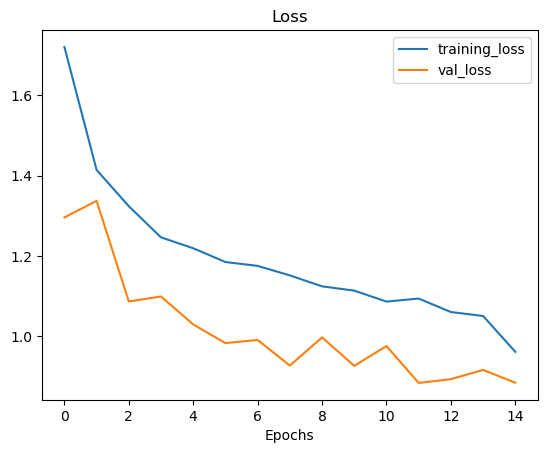

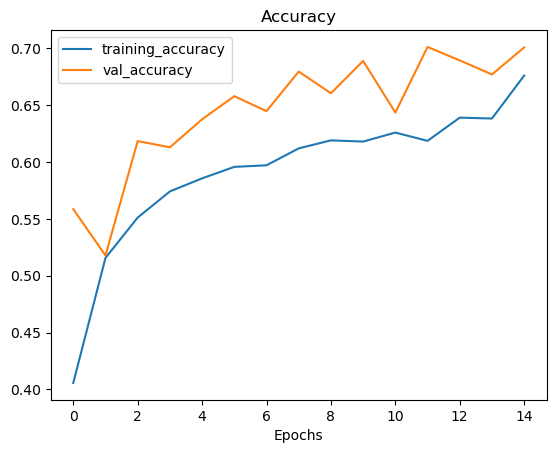

In [59]:
plot_loss_curves(MobileNet_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [60]:
test_loss, test_accuracy = MobileNet_model.evaluate(test_data, verbose=0)

In [61]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.89230
Test Accuracy: 68.89%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [62]:
pred_probs = MobileNet_model.predict(test_data, verbose=1)

74/74 [==============================] - 9s 110ms/step


In [63]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [64]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [65]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.50      0.80      0.61        95
  biological       0.70      0.73      0.71        99
   cardboard       0.79      0.77      0.78       234
     clothes       0.88      0.79      0.84       533
       glass       0.76      0.53      0.62       409
       metal       0.58      0.70      0.63       188
       paper       0.64      0.66      0.65       272
     plastic       0.57      0.57      0.57       253
       shoes       0.57      0.82      0.67       199
       trash       0.61      0.52      0.56        84

    accuracy                           0.69      2366
   macro avg       0.66      0.69      0.67      2366
weighted avg       0.71      0.69      0.69      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [66]:
import itertools

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

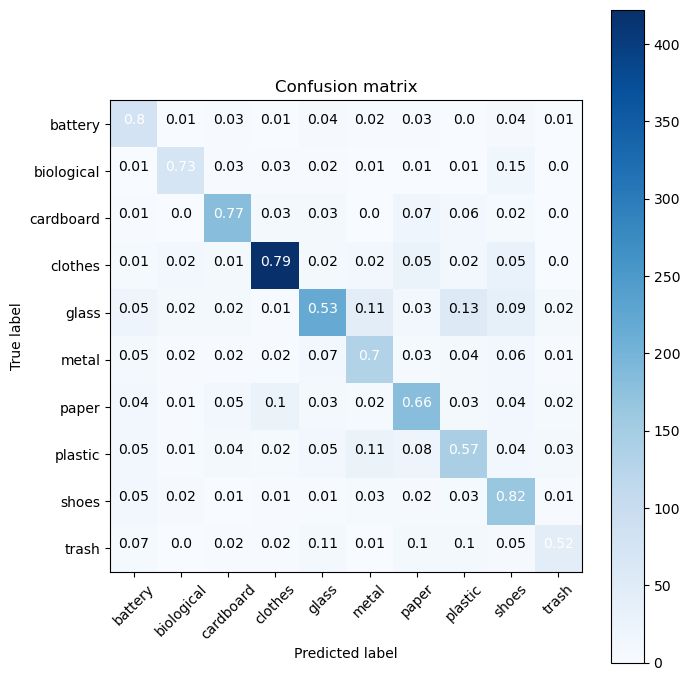

In [68]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [69]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon INFO @ 01:58:27] [setup] RAM Tracking...
[codecarbon INFO @ 01:58:27] [setup] GPU Tracking...
[codecarbon INFO @ 01:58:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:58:27] [setup] CPU Tracking...
[codecarbon WARNING @ 01:58:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:58:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:58:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:58:28] >>> Tracker's metadata:
[codecarbon INFO @ 01:58:28]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:58:28]   Python version: 3.10.10
[codecarbon INFO @ 01:58:28]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 01:58:28]   Available RAM : 31.358 GB
[codecarbon INFO @ 01:58:28]   CPU count: 4
[codecarbon INFO @ 01:58:28]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:58:28]   GPU

Deploy Model Carbon Emissions: 0.027469055324931303 kg


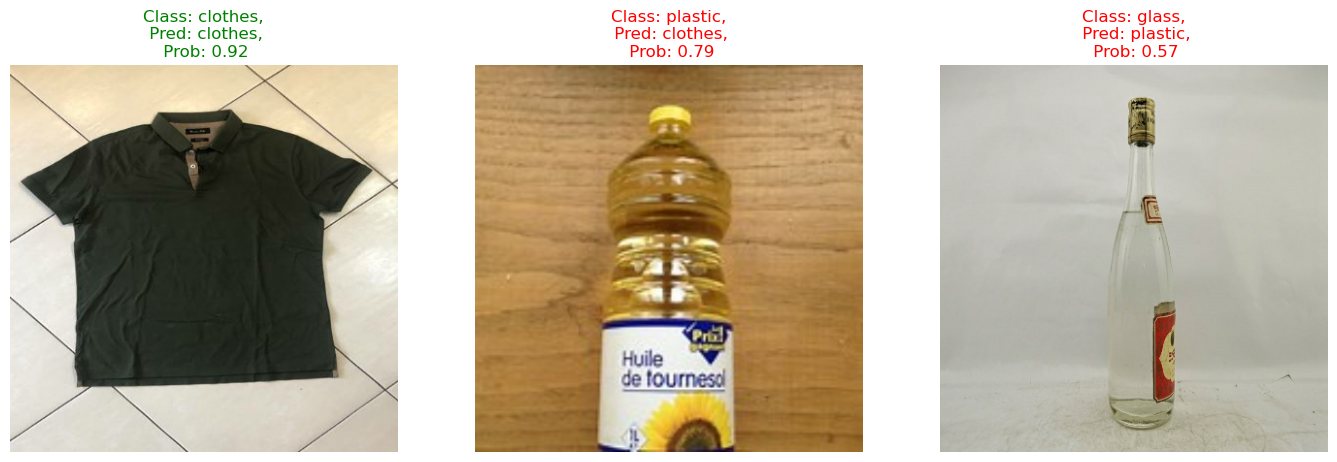

In [70]:
pred_random_images(MobileNet_model, test_path, class_names)

In [71]:
import pickle
pickle.dump(MobileNet_model,open("MobileNet_model.h5","wb"))

In [72]:
ls ../working

MobileNet.h5        data/                      logs/
MobileNet_model.h5  emissions.csv              logs.zip
__notebook__.ipynb  garbage-classification.h5  runs/
